In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.sparse import hstack
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harishvennakula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load and preprocess data
df = pd.read_csv('/Users/harishvennakula/Downloads/Combined Data.csv', index_col=0)
df.dropna(inplace=True)

In [3]:
# Basic text preprocessing function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)    # Remove mentions
    text = re.sub(r"[^\w\s]", "", text) # Remove punctuation
    return text.lower().strip()

In [4]:
# Apply text cleaning
df['statement'] = df['statement'].apply(clean_text)

In [5]:
# Tokenization and stemming
stemmer = PorterStemmer()
df['tokens'] = df['statement'].apply(word_tokenize)
df['tokens_stemmed'] = df['tokens'].apply(lambda tokens: ' '.join(stemmer.stem(token) for token in tokens))


In [6]:
# Feature extraction
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [7]:
# Label encoding
lbl_enc = LabelEncoder()
df['status_encoded'] = lbl_enc.fit_transform(df['status'])


In [8]:
# Split data
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [9]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

In [10]:
# Combine numerical and text features
X_train_combined = hstack([X_train_tfidf, X_train[['num_of_characters', 'num_of_sentences']].values])
X_test_combined = hstack([X_test_tfidf, X_test[['num_of_characters', 'num_of_sentences']].values])


In [11]:
# Oversampling
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)


In [12]:
# Define classifiers
classifiers = {
    'Naive Bayes': BernoulliNB(alpha=0.1),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101),
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}


Naive Bayes
Accuracy: 0.64
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.66      0.60      0.63       768
             Bipolar       0.69      0.58      0.63       566
          Depression       0.66      0.47      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.86      0.34      0.49       202
              Stress       0.41      0.52      0.46       530
            Suicidal       0.59      0.54      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



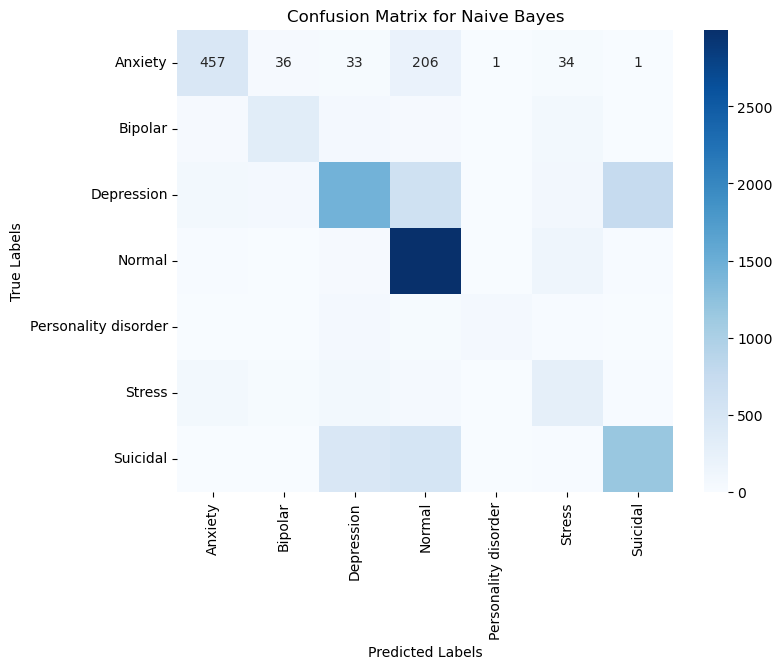


Decision Tree
Accuracy: 0.61
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.66      0.57      0.61       768
             Bipolar       0.82      0.45      0.58       566
          Depression       0.80      0.34      0.48      3050
              Normal       0.85      0.86      0.85      3237
Personality disorder       0.40      0.51      0.45       202
              Stress       0.18      0.71      0.28       530
            Suicidal       0.53      0.63      0.58      2184

            accuracy                           0.61     10537
           macro avg       0.61      0.58      0.55     10537
        weighted avg       0.71      0.61      0.62     10537



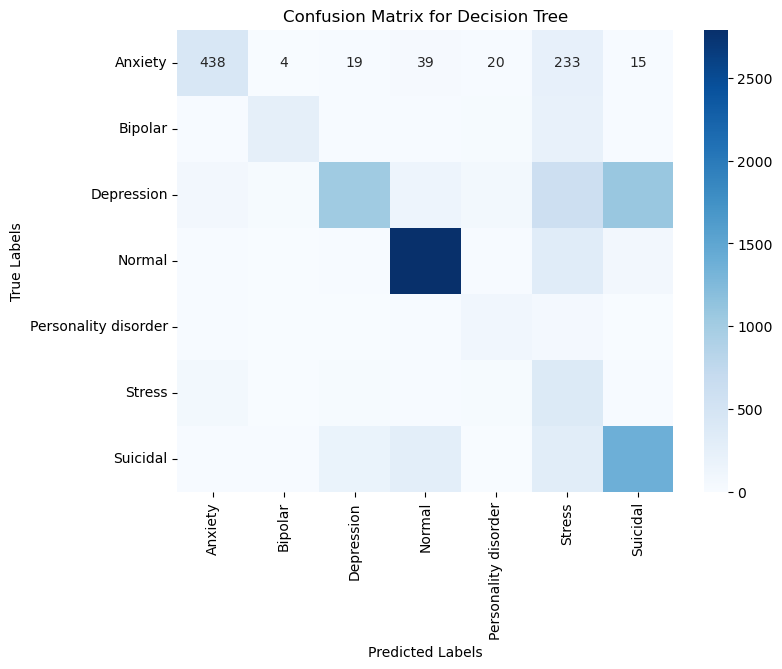


Logistic Regression
Accuracy: 0.77
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.81      0.80       768
             Bipolar       0.83      0.80      0.82       566
          Depression       0.72      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.72      0.65      0.68       202
              Stress       0.59      0.64      0.62       530
            Suicidal       0.65      0.68      0.67      2184

            accuracy                           0.77     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.77      0.76     10537



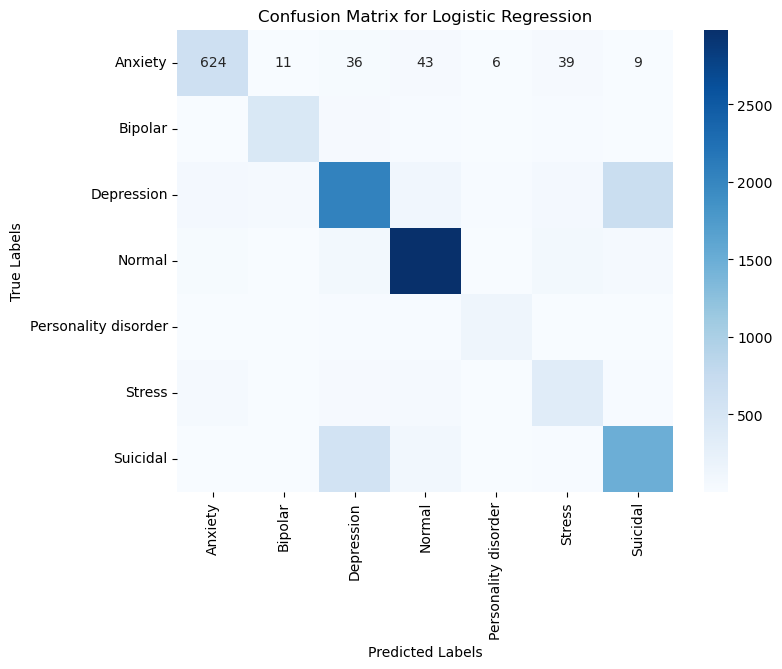

Error with classifier XGB: [17:10:57] /Users/runner/work/xgboost/xgboost/src/gbm/../common/common.h:174: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000015e804428 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000015e9d03f8 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 1276
  [bt] (2) 3   libxgboost.dylib                    0x000000015e9ef54c xgboost::LearnerConfiguration::Configure() + 1272
  [bt] (3) 4   libxgboost.dylib                    0x000000015e9ef

In [13]:
# Train and evaluate classifiers
accuracy_scores = {}
for name, clf in classifiers.items():
    try:
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test_combined)
        accuracy_scores[name] = accuracy_score(y_test, y_pred)

        print(f"\n{name}")
        print(f"Accuracy: {accuracy_scores[name]:.2f}")
        print("Classification Report:")
        print(classification_report(
            y_test, y_pred, target_names=lbl_enc.inverse_transform(range(len(lbl_enc.classes_)))
        ))

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=lbl_enc.inverse_transform(range(len(lbl_enc.classes_))),
                    yticklabels=lbl_enc.inverse_transform(range(len(lbl_enc.classes_))))
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    except Exception as e:
        print(f"Error with classifier {name}: {e}")


In [14]:
# Display summary of accuracy scores
print("\nSummary of Accuracy Scores:")
for name, score in accuracy_scores.items():
    print(f"{name}: {score:.2f}")


Summary of Accuracy Scores:
Naive Bayes: 0.64
Decision Tree: 0.61
Logistic Regression: 0.77


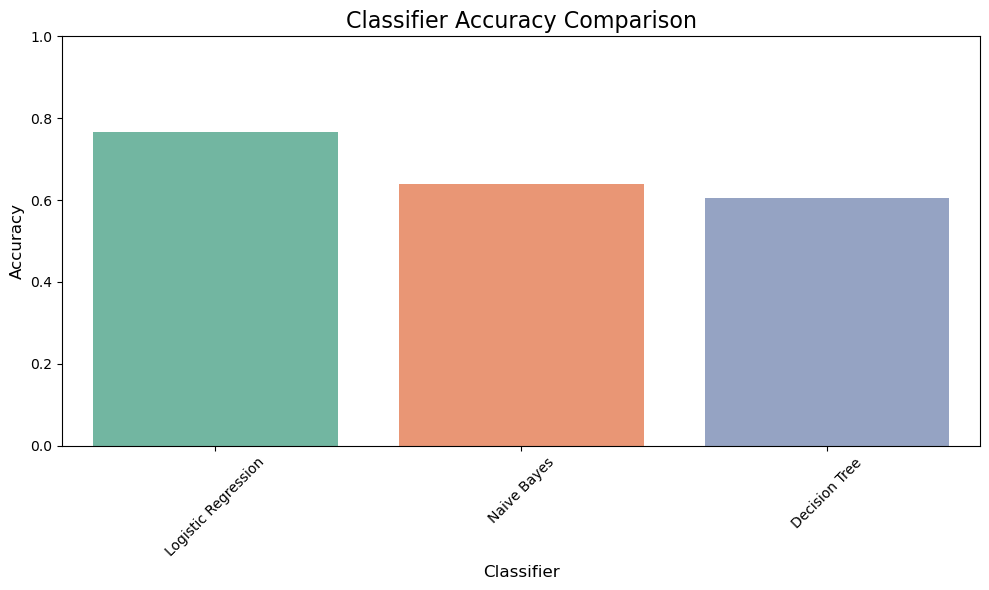

In [32]:
# Convert the accuracy_scores dictionary into a DataFrame
accuracies_df = pd.DataFrame(
    {'Classifier': list(accuracy_scores.keys()), 'Accuracy': list(accuracy_scores.values())}
).sort_values('Accuracy', ascending=False)

# Define a palette with distinct colors for classifiers
palette = sns.color_palette("Set2", len(accuracies_df))  # Use Set2 palette for aesthetics

# Plot the classifier accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

# Enhance plot appearance
plt.title("Classifier Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Classifier", fontsize=12)
plt.ylim(0, 1.0)  # Ensure the y-axis ranges from 0 to 1
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability

# Optimize layout and show the plot
plt.tight_layout()
plt.show()